# 6장 학습 관련 기술들
  - 6.1 매개변수의 갱신
  - 6.2 가중치의 초기화
  - 6.3 배치 정규화
  - 6.4 바른 학습을 위해
  - 6.5 적절한 하이퍼파라미터 값 찾기
  - 6.6 정리


https://colab.research.google.com/drive/1EG7l_zwa_hsjDrN9rdxDPGZjFhIvY6-U#scrollTo=FX62ekD8oRQF

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import tensorflow as tf

###layers


In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T

    x = x - np.max(x) # 오버플로 대책
    return np.exp(x) / np.sum(np.exp(x))

def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)

    # 훈련 데이터가 원-핫 벡터라면 정답 레이블의 인덱스로 반환
    if t.size == y.size:
        t = t.argmax(axis=1)

    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx


class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
        out = sigmoid(x)
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out

        return dx


class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b

        self.x = None
        self.original_x_shape = None
        # 가중치와 편향 매개변수의 미분
        self.dW = None
        self.db = None

    def forward(self, x):
        # 텐서 대응
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x

        out = np.dot(self.x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)

        dx = dx.reshape(*self.original_x_shape)  # 입력 데이터 모양 변경(텐서 대응)
        return dx


class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None # 손실함수
        self.y = None    # softmax의 출력
        self.t = None    # 정답 레이블(원-핫 인코딩 형태)

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)

        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size: # 정답 레이블이 원-핫 인코딩 형태일 때
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size

        return dx


class Dropout:
    """
    http://arxiv.org/abs/1207.0580
    """
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)

    def backward(self, dout):
        return dout * self.mask


class BatchNormalization:
    """
    http://arxiv.org/abs/1502.03167
    """
    def __init__(self, gamma, beta, momentum=0.9, running_mean=None, running_var=None):
        self.gamma = gamma
        self.beta = beta
        self.momentum = momentum
        self.input_shape = None # 합성곱 계층은 4차원, 완전연결 계층은 2차원

        # 시험할 때 사용할 평균과 분산
        self.running_mean = running_mean
        self.running_var = running_var

        # backward 시에 사용할 중간 데이터
        self.batch_size = None
        self.xc = None
        self.std = None
        self.dgamma = None
        self.dbeta = None

    def forward(self, x, train_flg=True):
        self.input_shape = x.shape
        if x.ndim != 2:
            N, C, H, W = x.shape
            x = x.reshape(N, -1)

        out = self.__forward(x, train_flg)

        return out.reshape(*self.input_shape)

    def __forward(self, x, train_flg):
        if self.running_mean is None:
            N, D = x.shape
            self.running_mean = np.zeros(D)
            self.running_var = np.zeros(D)

        if train_flg:
            mu = x.mean(axis=0)
            xc = x - mu
            var = np.mean(xc**2, axis=0)
            std = np.sqrt(var + 10e-7)
            xn = xc / std

            self.batch_size = x.shape[0]
            self.xc = xc
            self.xn = xn
            self.std = std
            self.running_mean = self.momentum * self.running_mean + (1-self.momentum) * mu
            self.running_var = self.momentum * self.running_var + (1-self.momentum) * var
        else:
            xc = x - self.running_mean
            xn = xc / ((np.sqrt(self.running_var + 10e-7)))

        out = self.gamma * xn + self.beta
        return out

    def backward(self, dout):
        if dout.ndim != 2:
            N, C, H, W = dout.shape
            dout = dout.reshape(N, -1)

        dx = self.__backward(dout)

        dx = dx.reshape(*self.input_shape)
        return dx

    def __backward(self, dout):
        dbeta = dout.sum(axis=0)
        dgamma = np.sum(self.xn * dout, axis=0)
        dxn = self.gamma * dout
        dxc = dxn / self.std
        dstd = -np.sum((dxn * self.xc) / (self.std * self.std), axis=0)
        dvar = 0.5 * dstd / self.std
        dxc += (2.0 / self.batch_size) * self.xc * dvar
        dmu = np.sum(dxc, axis=0)
        dx = dxc - dmu / self.batch_size

        self.dgamma = dgamma
        self.dbeta = dbeta

        return dx

### Multi_layer_net

In [ ]:
class MultiLayerNet:
    """완전연결 다층 신경망

    Parameters
    ----------
    input_size : 입력 크기（MNIST의 경우엔 784）
    hidden_size_list : 각 은닉층의 뉴런 수를 담은 리스트（e.g. [100, 100, 100]）
    output_size : 출력 크기（MNIST의 경우엔 10）
    activation : 활성화 함수 - 'relu' 혹은 'sigmoid'
    weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
        'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
        'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
    weight_decay_lambda : 가중치 감소(L2 법칙)의 세기
    """
    def __init__(self, input_size, hidden_size_list, output_size,
                 activation='relu', weight_init_std='relu', weight_decay_lambda=0):
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size_list = hidden_size_list
        self.hidden_layer_num = len(hidden_size_list)
        self.weight_decay_lambda = weight_decay_lambda
        self.params = {}

        # 가중치 초기화
        self.__init_weight(weight_init_std)

        # 계층 생성
        activation_layer = {'sigmoid': Sigmoid, 'relu': Relu}
        self.layers = OrderedDict()
        for idx in range(1, self.hidden_layer_num+1):
            self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)],
                                                      self.params['b' + str(idx)])
            self.layers['Activation_function' + str(idx)] = activation_layer[activation]()

        idx = self.hidden_layer_num + 1
        self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)],
            self.params['b' + str(idx)])

        self.last_layer = SoftmaxWithLoss()

    def __init_weight(self, weight_init_std):
        """가중치 초기화

        Parameters
        ----------
        weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
            'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
            'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
        """
        all_size_list = [self.input_size] + self.hidden_size_list + [self.output_size]
        for idx in range(1, len(all_size_list)):
            scale = weight_init_std
            if str(weight_init_std).lower() in ('relu', 'he'):
                scale = np.sqrt(2.0 / all_size_list[idx - 1])  # ReLU를 사용할 때의 권장 초깃값
            elif str(weight_init_std).lower() in ('sigmoid', 'xavier'):
                scale = np.sqrt(1.0 / all_size_list[idx - 1])  # sigmoid를 사용할 때의 권장 초깃값
            self.params['W' + str(idx)] = scale * np.random.randn(all_size_list[idx-1], all_size_list[idx])
            self.params['b' + str(idx)] = np.zeros(all_size_list[idx])

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    # ========= 가중치 감소 =============
    def loss(self, x, t):
        """손실 함수를 구한다.

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블

        Returns
        -------
        손실 함수의 값
        """
        y = self.predict(x)

        weight_decay = 0
        for idx in range(1, self.hidden_layer_num + 2):
            W = self.params['W' + str(idx)]
            weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W ** 2)

        return self.last_layer.forward(y, t) + weight_decay

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)

        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    def numerical_gradient(self, x, t):
        """기울기를 구한다(수치 미분).

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블

        Returns
        -------
        각 층의 기울기를 담은 딕셔너리(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        loss_W = lambda W: self.loss(x, t)

        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads['W' + str(idx)] = numerical_gradient(loss_W, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_W, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """기울기를 구한다(오차역전파법).

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블

        Returns
        -------
        각 층의 기울기를 담은 딕셔너리(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads['W' + str(idx)] = self.layers['Affine' + str(idx)].dW + self.weight_decay_lambda * self.layers['Affine' + str(idx)].W
            grads['b' + str(idx)] = self.layers['Affine' + str(idx)].db

        return grads

### multi_layer_net_extend

In [ ]:
class MultiLayerNetExtend:
    """완전 연결 다층 신경망(확장판)
    가중치 감소, 드롭아웃, 배치 정규화 구현

    Parameters
    ----------
    input_size : 입력 크기（MNIST의 경우엔 784）
    hidden_size_list : 각 은닉층의 뉴런 수를 담은 리스트（e.g. [100, 100, 100]）
    output_size : 출력 크기（MNIST의 경우엔 10）
    activation : 활성화 함수 - 'relu' 혹은 'sigmoid'
    weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
        'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
        'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
    weight_decay_lambda : 가중치 감소(L2 법칙)의 세기
    use_dropout : 드롭아웃 사용 여부
    dropout_ration : 드롭아웃 비율
    use_batchNorm : 배치 정규화 사용 여부
    """
    def __init__(self, input_size, hidden_size_list, output_size,
                 activation='relu', weight_init_std='relu', weight_decay_lambda=0,
                 use_dropout = False, dropout_ration = 0.5, use_batchnorm=False):
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size_list = hidden_size_list
        self.hidden_layer_num = len(hidden_size_list)
        self.use_dropout = use_dropout
        self.weight_decay_lambda = weight_decay_lambda
        self.use_batchnorm = use_batchnorm
        self.params = {}

        # 가중치 초기화
        self.__init_weight(weight_init_std)

        # 계층 생성
        activation_layer = {'sigmoid': Sigmoid, 'relu': Relu}
        self.layers = OrderedDict()
        for idx in range(1, self.hidden_layer_num+1):
            self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)],
                                                      self.params['b' + str(idx)])
            if self.use_batchnorm:
                self.params['gamma' + str(idx)] = np.ones(hidden_size_list[idx-1])
                self.params['beta' + str(idx)] = np.zeros(hidden_size_list[idx-1])
                self.layers['BatchNorm' + str(idx)] = BatchNormalization(self.params['gamma' + str(idx)], self.params['beta' + str(idx)])

            self.layers['Activation_function' + str(idx)] = activation_layer[activation]()

            if self.use_dropout:
                self.layers['Dropout' + str(idx)] = Dropout(dropout_ration)

        idx = self.hidden_layer_num + 1
        self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)], self.params['b' + str(idx)])

        self.last_layer = SoftmaxWithLoss()

    def __init_weight(self, weight_init_std):
        """가중치 초기화

        Parameters
        ----------
        weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
            'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
            'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
        """
        all_size_list = [self.input_size] + self.hidden_size_list + [self.output_size]
        for idx in range(1, len(all_size_list)):
            scale = weight_init_std
            if str(weight_init_std).lower() in ('relu', 'he'):
                scale = np.sqrt(2.0 / all_size_list[idx - 1])  # ReLU
            elif str(weight_init_std).lower() in ('sigmoid', 'xavier'):
                scale = np.sqrt(1.0 / all_size_list[idx - 1])  # sigmoid
            self.params['W' + str(idx)] = scale * np.random.randn(all_size_list[idx-1], all_size_list[idx])
            self.params['b' + str(idx)] = np.zeros(all_size_list[idx])

    def predict(self, x, train_flg=False):
        for key, layer in self.layers.items():
            if "Dropout" in key or "BatchNorm" in key:
                x = layer.forward(x, train_flg)
            else:
                x = layer.forward(x)

        return x

    def loss(self, x, t, train_flg=False):
        """손실 함수를 구한다.

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        """
        y = self.predict(x, train_flg)

        weight_decay = 0
        for idx in range(1, self.hidden_layer_num + 2):
            W = self.params['W' + str(idx)]
            weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)

        return self.last_layer.forward(y, t) + weight_decay

    def accuracy(self, X, T):
        Y = self.predict(X, train_flg=False)
        Y = np.argmax(Y, axis=1)
        if T.ndim != 1 : T = np.argmax(T, axis=1)

        accuracy = np.sum(Y == T) / float(X.shape[0])
        return accuracy

    ####### 배치정규화 #############
    def numerical_gradient(self, X, T):
        """기울기를 구한다(수치 미분).

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블

        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        loss_W = lambda W: self.loss(X, T, train_flg=True)

        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads['W' + str(idx)] = numerical_gradient(loss_W, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_W, self.params['b' + str(idx)])

            if self.use_batchnorm and idx != self.hidden_layer_num+1:
                grads['gamma' + str(idx)] = numerical_gradient(loss_W, self.params['gamma' + str(idx)])
                grads['beta' + str(idx)] = numerical_gradient(loss_W, self.params['beta' + str(idx)])

        return grads

    def gradient(self, x, t):
        # forward
        self.loss(x, t, train_flg=True)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads['W' + str(idx)] = self.layers['Affine' + str(idx)].dW + self.weight_decay_lambda * self.params['W' + str(idx)]
            grads['b' + str(idx)] = self.layers['Affine' + str(idx)].db

            if self.use_batchnorm and idx != self.hidden_layer_num+1:
                grads['gamma' + str(idx)] = self.layers['BatchNorm' + str(idx)].dgamma
                grads['beta' + str(idx)] = self.layers['BatchNorm' + str(idx)].dbeta

        return grads

### trainer

In [ ]:
class Trainer:
    """
    신경망 훈련을 대신 해주는 클래스
    """
    def __init__(self, network, x_train, t_train, x_test, t_test,
                 epochs=20, mini_batch_size=100,
                 optimizer='SGD', optimizer_param={'lr':0.01},
                 evaluate_sample_num_per_epoch=None, verbose=True):
        self.network = network
        self.verbose = verbose
        self.x_train = x_train
        self.t_train = t_train
        self.x_test = x_test
        self.t_test = t_test
        self.epochs = epochs
        self.batch_size = mini_batch_size
        self.evaluate_sample_num_per_epoch = evaluate_sample_num_per_epoch

        # optimzer
        optimizer_class_dict = {'sgd':SGD, 'momentum':Momentum, 'nesterov':Nesterov,
                                'adagrad':AdaGrad, 'rmsprpo':RMSprop, 'adam':Adam}
        self.optimizer = optimizer_class_dict[optimizer.lower()](**optimizer_param)

        self.train_size = x_train.shape[0]
        self.iter_per_epoch = max(self.train_size / mini_batch_size, 1)
        self.max_iter = int(epochs * self.iter_per_epoch)
        self.current_iter = 0
        self.current_epoch = 0

        self.train_loss_list = []
        self.train_acc_list = []
        self.test_acc_list = []

    def train_step(self):
        batch_mask = np.random.choice(self.train_size, self.batch_size)
        x_batch = self.x_train[batch_mask]
        t_batch = self.t_train[batch_mask]

        grads = self.network.gradient(x_batch, t_batch)
        self.optimizer.update(self.network.params, grads)

        loss = self.network.loss(x_batch, t_batch)
        self.train_loss_list.append(loss)
        if self.verbose: print("train loss:" + str(loss))

        if self.current_iter % self.iter_per_epoch == 0:
            self.current_epoch += 1

            x_train_sample, t_train_sample = self.x_train, self.t_train
            x_test_sample, t_test_sample = self.x_test, self.t_test
            if not self.evaluate_sample_num_per_epoch is None:
                t = self.evaluate_sample_num_per_epoch
                x_train_sample, t_train_sample = self.x_train[:t], self.t_train[:t]
                x_test_sample, t_test_sample = self.x_test[:t], self.t_test[:t]

            train_acc = self.network.accuracy(x_train_sample, t_train_sample)
            test_acc = self.network.accuracy(x_test_sample, t_test_sample)
            self.train_acc_list.append(train_acc)
            self.test_acc_list.append(test_acc)

            if self.verbose: print("=== epoch:" + str(self.current_epoch) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc) + " ===")
        self.current_iter += 1

    def train(self):
        for i in range(self.max_iter):
            self.train_step()

        test_acc = self.network.accuracy(self.x_test, self.t_test)

        if self.verbose:
            print("=============== Final Test Accuracy ===============")
            print("test acc:" + str(test_acc))


## 6.1 매개변수 갱신

## optimizer class
손실함수 값이 최소가되는 매개변수를 찾음 = 최적화 (optimize
)


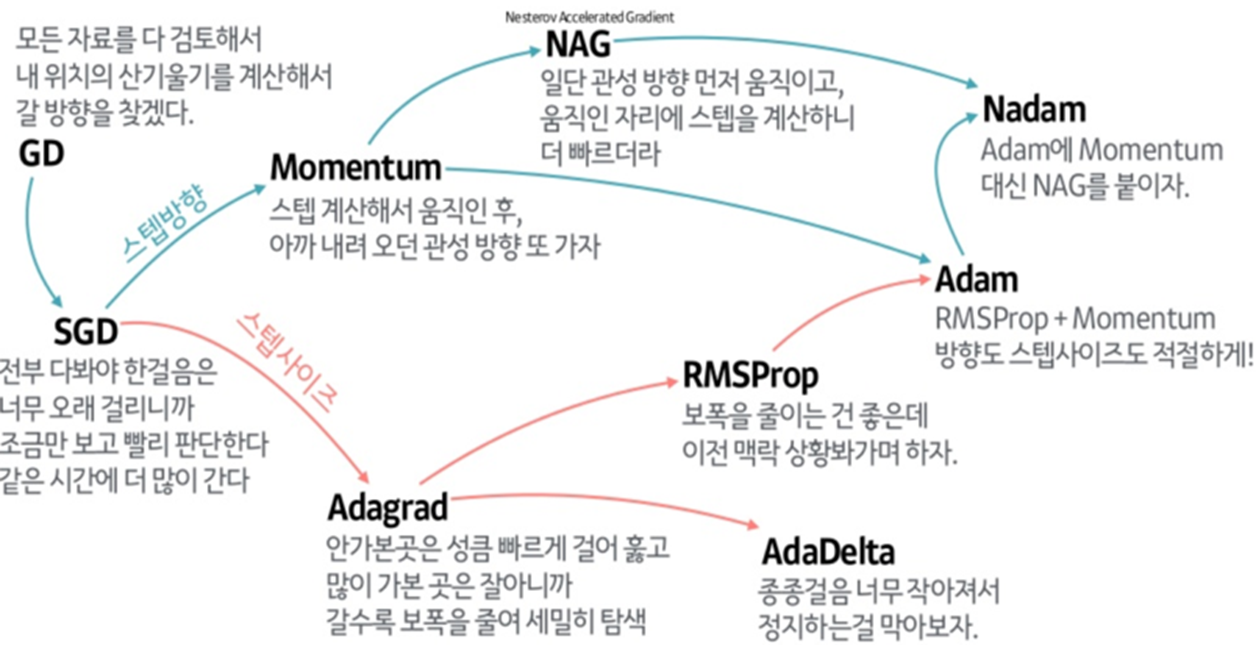

- http://beamlab.org/deeplearning/2017/02/23/deep_learning_101_part2.html

- https://medium.com/aimonks/optimizers-the-secret-sauce-of-deep-learning-c0f09cc98bd5

### SGD - 확률적 경사 하강법

$$ W := W - \eta \frac{\partial L}{\partial W}$$  

$$ W : 갱신할매개변수 $$
$$\eta \frac{\partial L}{\partial W} : W 에 대한 손실함수의 기울기$$  

$$ \eta : 학습률, 미리 정해서 사용 $$


In [ ]:
class SGD:

    """확률적 경사 하강법（Stochastic Gradient Descent）"""

    def __init__(self, lr=0.001):
        self.lr = lr

    #params = 가중치 / grads = 기울기
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

 - 의사 코드


```
network = TwoLayerNet(...)
optimizer = SGD()

for i in range(10000)
    ...
    x_batch, t_batch = get_mini_batch(...) # 미니배치
    grads = network.gradient(x_batch, t_batch)
    params = network.params
    optimizer.update(params, grads)
    ...
```




단점: 기울기가 달라지는 함수에서는 탐색경로 비효율적 (지그재그)


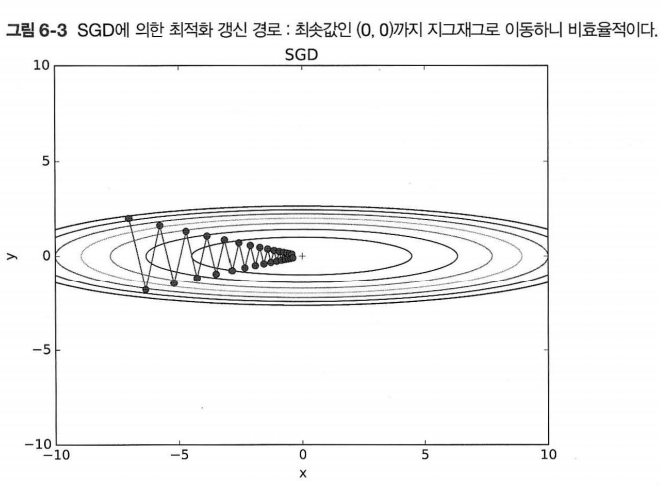

### Momentum

\begin{equation*}
v \leftarrow \alpha v - \eta \frac{\partial{L}}{\partial{W}}
\end{equation*}

\begin{equation*}
W \leftarrow W + v
\end{equation*}

\begin{equation*}
W : 갱신할 매개변수
\end{equation*}
\begin{equation*}
\frac{\partial L}{\partial W} : 손실 함수의 기울기
\end{equation*}
\begin{equation*}
\eta : 학습률, 미리 정해서 사용
\end{equation*}
\begin{equation*}
v : 물리에서 말하는 속도(velocity)
\end{equation*}

In [ ]:
class Momentum:
    def __init__(self, lr=0.001, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
    # v는 초기화x , update 호출시 매개변수와 같은 구조의 데이터 딕셔너리로 저장
    def update(self, params, grads):
        if self.v is None:                     # 처음 한번만 실행됨
            self.v = {}
            for key, val in params.items():    # key, value 쌍 얻기  [(1,1),(2,2)]
                self.v[key] = np.zeros_like(val)

        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key]
            params[key] += self.v[key]

SGD에 비해 지그재그 움직임 줄어듬


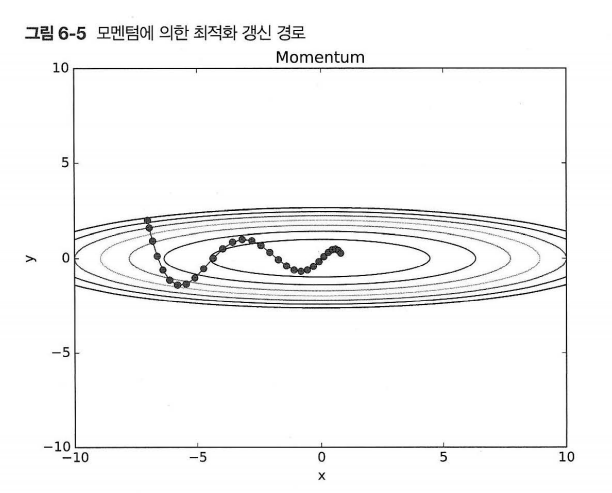

### Nesterov

- 모멘텀의 방향으로 조금 앞선 곳에서 손실함수의 그라디언트를 구함
- 시간이 지날수록 조금 더 빨리 최솟값에 도달
- Nesterov 수식

  $
  \qquad m \ \leftarrow \  \beta m - \eta \bigtriangledown_\theta J(\theta + \beta m) \\
  \qquad \theta \ \leftarrow \ \theta \ + m
  $

  - $h\ $ : 기존 기울기를 제곱하여 더한 값
  - $\eta\ $ : 학습률
  - $\bigtriangledown_\theta J(\theta) \ $ : $\theta$에 대한 미분(그라디언트)

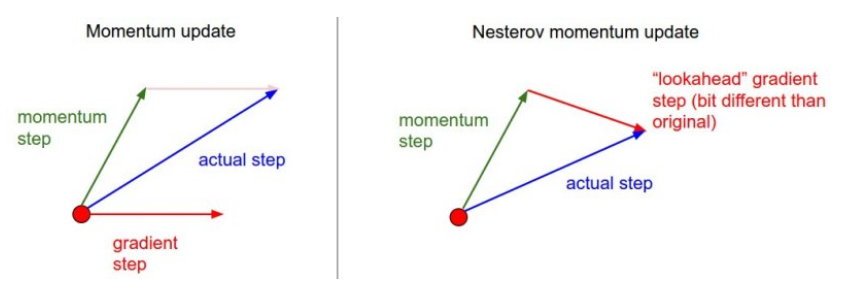

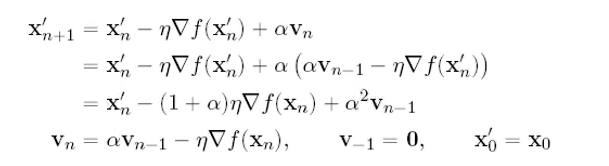

In [ ]:
# 일단 관성 방향 먼저 움직이고, 움직인 자리에 스텝을 계산하니 더 빠르더라
class Nesterov:

    """Nesterov's Accelerated Gradient (http://arxiv.org/abs/1212.0901)"""
    # NAG는 모멘텀에서 한 단계 발전한 방법이다. (http://newsight.tistory.com/224)

    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None

    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)

        for key in params.keys():
            self.v[key] *= self.momentum
            self.v[key] -= self.lr * grads[key]
            params[key] += self.momentum * self.momentum * self.v[key]
            params[key] -= (1 + self.momentum) * self.lr * grads[key]

### AdaGrad
신경망 학습시 중요한 학습률을 점차 줄여감
 : 각각의 매개변수에 맞게 학습률 조정



\begin{equation*}
h := h + \frac{\partial{L}}{\partial{W}} \odot \frac{\partial{L}}{\partial{W}}
\end{equation*}


\begin{equation*}
W := W - \eta \frac{1}{\sqrt{h}} \frac{\partial{L}}{\partial{W}}
\end{equation*}

\begin{equation*}
W : 갱신할 매개변수
\end{equation*}
\begin{equation*}
\frac{\partial L}{\partial W} : 손실 함수의 기울기
\end{equation*}
\begin{equation*}
\eta : 학습률, 미리 정해서 사용
\end{equation*}

h : 기존 기울기 값을 제곱하여 계속 더해줌

매개변수를 갱신할 때 1/sqrt(h)을 곱해 학습률을 조정

AdaGrad는 학습을 진행할 수록 갱신 강도가 약해짐.

In [ ]:
#============PASS=============
class AdaGrad:

    """AdaGrad"""

    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None

    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)

        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)
            # 1e-7 은 0으로 나누지 않게하는 값

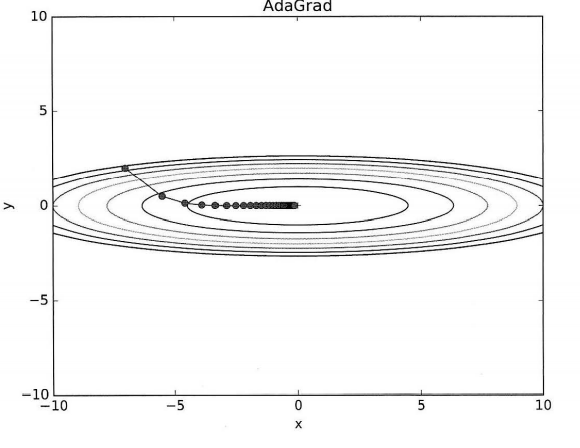

### RMSProp (Root Mean Square Propagation)

- AdaGrad를 보완하기 위한 방법으로 등장
- 합 대신 지수의 평균값을 활용
- 학습이 안되기 시작하면 학습률이 커져서 잘 되게하고, 학습률이 너무 크면 학습률을 다시 줄임
- RMSProp 수식

  $
  \qquad h \ \leftarrow \  \rho \ h + (1 - \rho)\ \frac{\partial L}{\partial W} \odot \frac{\partial L}{\partial W} \\
  \qquad W \ \leftarrow \ W \ + \eta \frac{1}{\sqrt{h + \epsilon}} \frac{\partial L}{\partial W}
  $
  
  - $h\ $ : 기존 기울기를 제곱하여 업데이트 계수를 곱한 값과 업데이트 계수를 곱한 값을 더해줌
  - $\rho\ $ : 지수 이동 평균의 업데이트 계수
    - 지수이동평균(Exponential Moving Average)은 과거의 모든 기간을 계산대상으로 하며 최근의 데이타에 더 높은 가중치를 두는 일종의 가중이동평균법
  - $\eta $ : 학습률
  - $\frac{\partial L}{\partial W}\ $ : $W$에 대한 미분

In [ ]:
class RMSprop:

    """RMSprop"""

    def __init__(self, lr=0.01, decay_rate = 0.99):
        self.lr = lr
        self.decay_rate = decay_rate
        self.h = None

    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)

        for key in params.keys():
            self.h[key] *= self.decay_rate
            self.h[key] += (1 - self.decay_rate) * grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

### Adam = AdaGrad + Momentum

매개변수 효율적 탐색 + 하이퍼파라미터 값 편향 보정



In [ ]:
class Adam:

    """Adam (http://arxiv.org/abs/1412.6980v8)"""

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None

    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)

        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)

        for key in params.keys():
            #self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            #self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])

            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)

            #unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            #unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            #params[key] += self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)

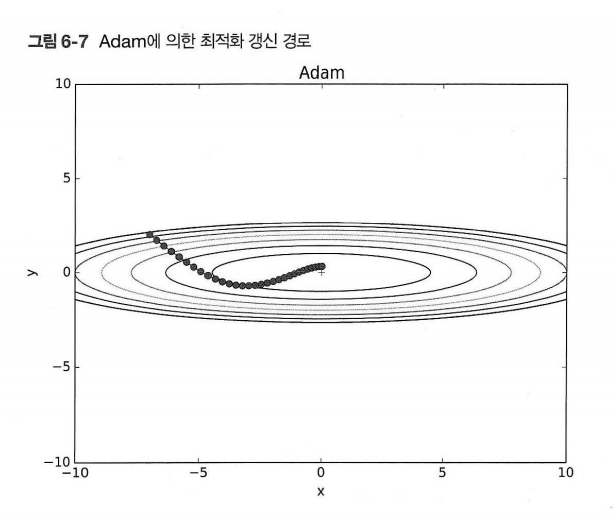

### 4가지 optimizer 비교

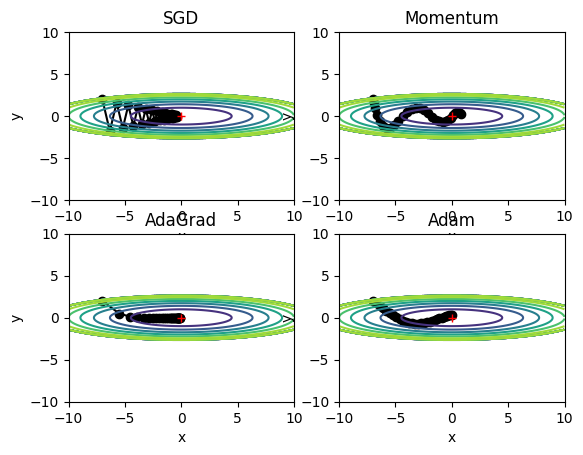

In [ ]:
def f(x, y):
    return x**2 / 20.0 + y**2


def df(x, y):
    return x / 10.0, 2.0*y

init_pos = (-7.0, 2.0)
params = {}
params['x'], params['y'] = init_pos[0], init_pos[1]
grads = {}
grads['x'], grads['y'] = 0, 0

#각 optimizer
optimizers = OrderedDict()
optimizers["SGD"] = SGD(lr=0.95)
optimizers["Momentum"] = Momentum(lr=0.1)
optimizers["AdaGrad"] = AdaGrad(lr=1.5)
optimizers["Adam"] = Adam(lr=0.3)

idx = 1

for key in optimizers:   # SGD  Momentum  AdaGrad Adam 순으로 나온다.
    optimizer = optimizers[key]
    x_history = []
    y_history = []
    params['x'], params['y'] = init_pos[0], init_pos[1]

    for i in range(30):
        x_history.append(params['x'])
        y_history.append(params['y'])

        grads['x'], grads['y'] = df(params['x'], params['y'])
        optimizer.update(params, grads)


    x = np.arange(-10, 10, 0.01)
    y = np.arange(-5, 5, 0.01)

    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)

    # 외곽선 단순화
    mask = Z > 7
    Z[mask] = 0

    # 그래프 그리기
    #plt.figure(figsize = (10,10))
    plt.subplot(2, 2, idx)
    idx += 1
    plt.plot(x_history, y_history, 'o-', color="black")
    plt.contour(X, Y, Z)
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    plt.plot(0, 0, '+', color="red")
    #colorbar()
    #spring()
    plt.title(key)
    plt.xlabel("x")
    plt.ylabel("y")

plt.show()

### optimizer MNIST로 비교

In [ ]:
def smooth_curve(x):
    """손실 함수의 그래프를 매끄럽게 하기 위해 사용

    참고：http://glowingpython.blogspot.jp/2012/02/convolution-with-numpy.html
    """
    window_len = 11
    s = np.r_[x[window_len-1:0:-1], x, x[-1:-window_len:-1]]
    w = np.kaiser(window_len, 2)
    y = np.convolve(w/w.sum(), s, mode='valid')
    return y[5:len(y)-5]



In [ ]:
import tensorflow as tf

(x_train,t_train),(x_test,t_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.reshape(60000,-1) #flatten (60000,28,28) - > (60000,784)
x_train = x_train.astype('float32') / 255. #normalize 데이터를 0과 1사이로

x_test = x_test.reshape(10000,-1)
x_test = x_test.astype('float32') / 255. #normalize 데이터를 0과 1사이로

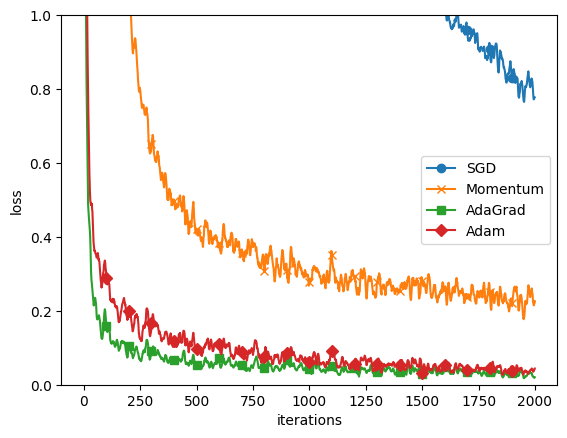

In [ ]:
train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1. 실험용 설정==========
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
#optimizers['RMSprop'] = RMSprop()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []


# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)

        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)

    if i % 100 == 0:
        #print( "===========" + "iteration:" + str(i) + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            #print(key + ":" + str(loss))


# 3. 그래프 그리기==========
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()

## 6.2 가중치의 초깃값
### 초기값 설정
 - 0 : 학습이 올바로 이루어지지 않음
 - ramdom(정규분포) :  1인 경우 양쪽으로 치우쳐서 분포함, 0.01인 경우 가운데로만 분포함 표현력이 적다.
 - Xavier(sigmoid) : 전체 영역에서 골고루 퍼지게 됨
 - He(ReLu) : Xavier 방식보다 2배의 계수가 필요함

### 가중치 감소

: 매개변수의 값이 작아지도록 학습하여 오버피팅 일어나지 않도록 함

: 초깃값이 0일 경우 오차역전파에서 모든 가중치 값 똑같이 갱신됨 , 무작위 설정 !

https://colab.research.google.com/drive/1ZMgdyliobiY8qI3wfXcAiRkJJ5oJptzJ



---


#### 가중치를 표준편차가 1인 정규분포로 초기화할 때의 각 층의 활성화값 분포(기울기 소실)
  - 0과 1에 치우쳐 있음
  - 0 또는 1인 경우 미분값은 0에 다가감 -> 기울기 소실(Gradient vanishing) 현상이 있음

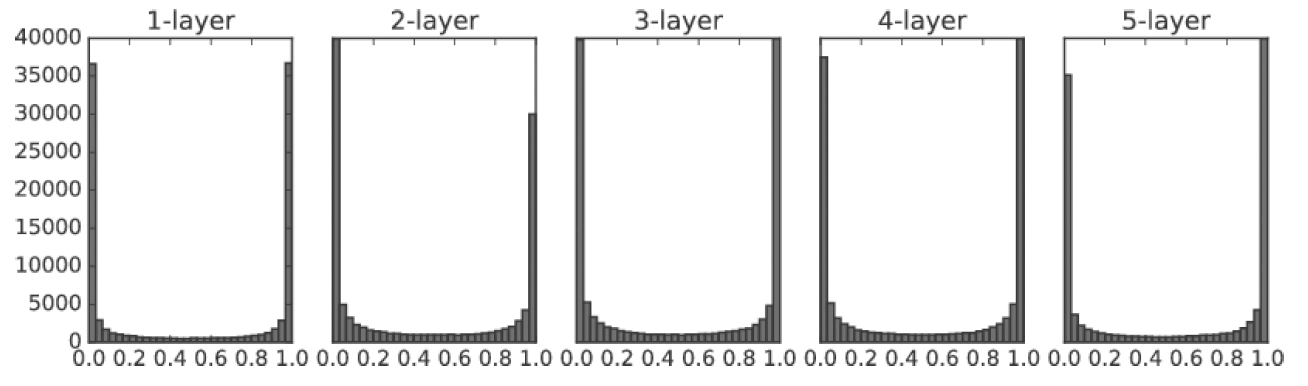


---
#### 가중치를 표준편차가 0.01인 정규분포로 초기화할 때의 각 층의 활성화값 분포(표현력 제한)
  - 0.5 부근에 집중 : 활성화값이 치우쳤다는 것은 표현력 관점에서 문제가 있음
    - 다수의 뉴런이 같은 값을 출력하고 있으니 뉴런을 여러개 둔 의미가 없다는 뜻임
    - 예) 100개의 뉴런이 거의 같은 값을 출력한다면 뉴런 1개짜리와 별반 다를 게 없다는 듯
  - 기울기 소실(Gradient vanishing) 문제는 일어나지 않음

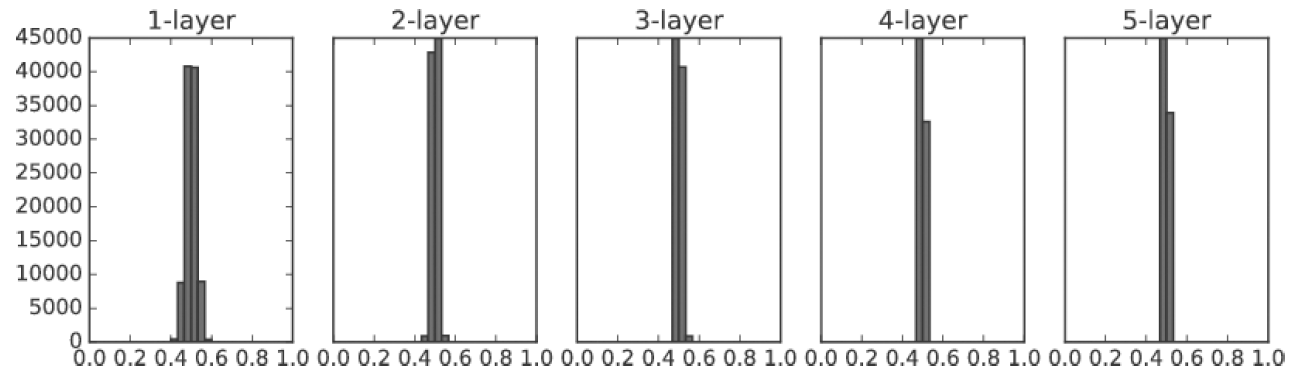



---


#### 가중치를 표준편차으로 '**Xavier 초기값**'을 이용할 때의 각 층의 활성화값 분포
  - 층이 깊어지면서 형태가 다소 일그러지지만, 비교적 넓게 분포됨

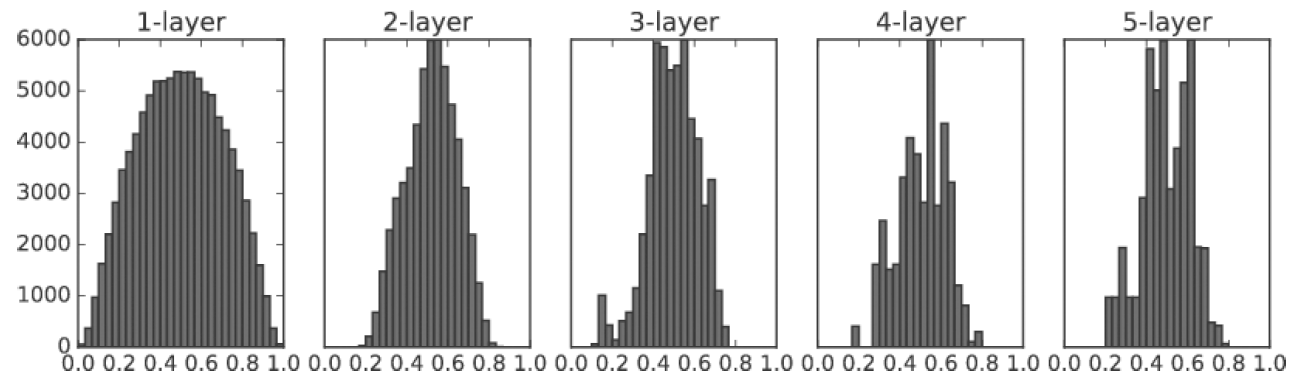

In [ ]:
# 층 5개
# 각 층당 뉴런 100개
# 입력 데이터 1000개의 데이터를 정규분포로 무작위로 생성
# 각 층의 활성화 결과를 activates 변수에 저장
# 각 코드이 가중치 분포 관찰
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
  return 1 / (1 + np.exp(-x))

def relu(x):
  return np.maximum(0, x)

x = np.random.randn(1000, 100) # 1000개의 데이터
node_num = 100           # 각 은닉층의 노드(뉴런) 수
hidden_layer_size = 5    # 은닉층이 5개
activates = {}           # 이곳에 활성화 결과(활성화값)를 저장

for i in range(hidden_layer_size):
  if i != 0:
    x = activates[i-1]

  #w = np.random.randn(node_num, node_num) * 0.000001              # 0으로 초기화

  #w = np.zeros((node_num,node_num))                                # 0으로 초기화
  w = np.random.uniform(1,10,(node_num,node_num))
  #w = np.random.randn(node_num, node_num) * 1                     # 표준 편차가    1인 정규분포의 경우
  #w = np.random.randn(node_num, node_num) * 0.01                  # 표준 편차가 0.01인 정규분포의 경우
  #w = np.random.randn(node_num, node_num) / np.sqrt(node_num)      # Xavier
  #w = np.random.randn(node_num, node_num) / np.sqrt(node_num / 2)  # He
  a = np.dot(x, w)

  z = sigmoid(a)
  #z = relu(a)

  activates[i] = z

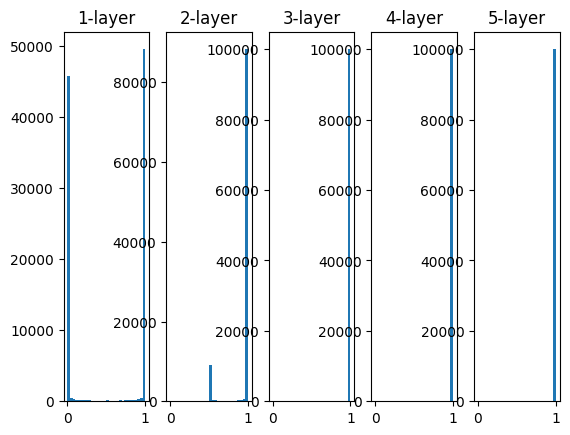

In [ ]:
# 히스토그램 그리기
for i, a in activates.items():
  plt.subplot(1, len(activates), i+1)
  plt.title(str(i+1) + "-layer")
  plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

### 1. Xavier 초깃값
(활성화함수가 선형일때 : sigmoid, tanh)

앞 계층의 노드가 n개 : 초깃값의 표준편차가 1/root(n) 이 되도록 설정

### 2. He 초깃값 : ReLU 사용시

앞 계층의 노드가 n개 : 초깃값의 표준편차가 root(2/n) 이 되도록 설정

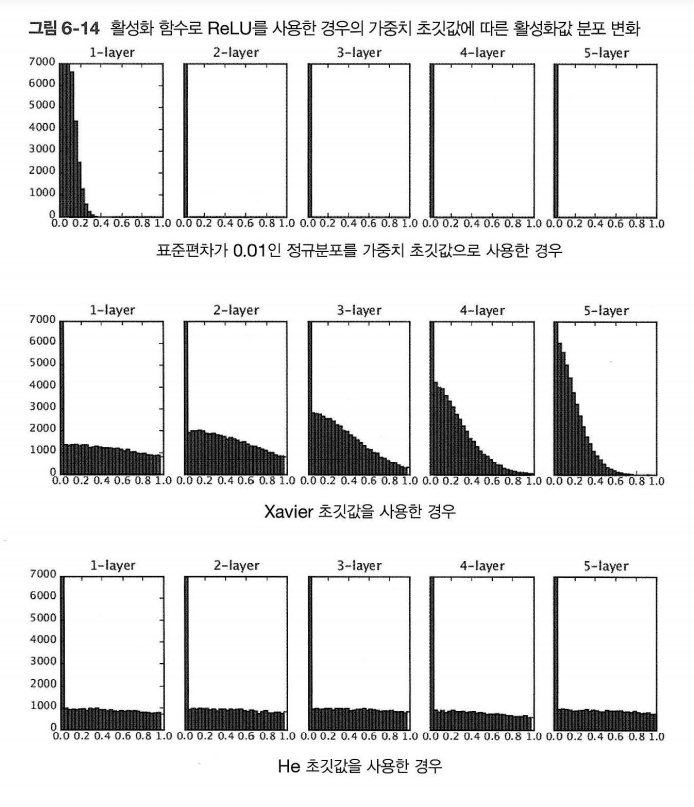

std = 0.01 : 활성화값이 너무 작아서 학습이 거의 이루어지지 않음.
  - 신경망에 아주 작은 데이터가 흐른다는 것은 역전파 때 가중치의 기울기 역시 작아진다는 의미임

Xavier : 층이 깊어지면서 활성화값이 치우침 : 기울기 소실

He : 층이 깊어져도 분포가 균일 --> 역전파 때도 적절한 값 나옴

## 초깃값 MNIST 비교


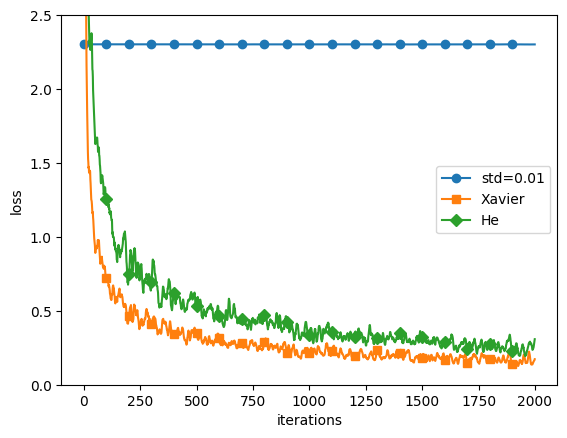

In [ ]:
(x_train,t_train),(x_test,t_test) = tf.keras.datasets.mnist.load_data()

#x_train = x_train.reshape(60000,-1) #flatten (60000,28,28) - > (60000,784)
#x_test = x_test.reshape(10000,-1)

x_test = x_test.reshape(10000,-1)
x_test = x_test.astype('float32') / 255. #normalize 데이터를 0과 1사이로

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1. 실험용 설정==========
weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
optimizer = SGD(lr=0.001)

networks = {}
train_loss = {}
for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                  output_size=10, weight_init_std=weight_type)
    train_loss[key] = []


# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    for key in weight_init_types.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)

        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)

    if i % 100 == 0:
        #print("===========" + "iteration:" + str(i) + "===========")
        for key in weight_init_types.keys():
            loss = networks[key].loss(x_batch, t_batch)
            #print(key + ":" + str(loss))


# 3. 그래프 그리기==========
markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(max_iterations)
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()
plt.show()

## 6.3 배치정규화

: 앞절에서 가중치의 초기값을 적절히 설정하면 각 층의 활성화값 분포가 적당히 퍼지면서 학습이 원할하게 수행된다는 것을 배웠음

: 활성화값 분포를 강제로 적당히 퍼지게 하는 것 -> 배치 정규화(Batch Normalization)

### 6.3.1 배치 정규화 알고리즘

: 각 층의 활성화값이 적당히 분포되도록 조정하여 학습이 원활하게 진행되도록 함



- 학습속도 빨라짐
- 초깃값에 크게 의존하지 않음
- 오버피팅 억제

\begin{equation*}
\mu_{B} := \frac{1}{m} \sum^{m}_{i=1} x_{i}
\end{equation*}
\begin{equation*}
\sigma^{2}_{B} := \frac{1}{m} \sum^{m}_{i=1} (x_{i} - \mu_{B})^{2}
\end{equation*}
\begin{equation*}
\hat{x_{i}} := \frac{x_{i}-\mu_{B}}{\sqrt{\sigma^{2}_{B}+\epsilon}}
\end{equation*}

미니배치 B={x1, x2, ..., xm}

- 1. 미니배치 단위로  평균 0, 분산 1이 되도록 정규화
- 2. 배치 정규화 계층마다 정규된 데이터에 대한 고유한 확대와 이동변환 수행

\begin{equation*}
y_{i} = \gamma \hat{x_{i}} + \beta
\end{equation*}

gamma가 확대, beta가 이동을 담당  
두 값은 처음에는 1, 0으로 (원본 그대로) 학습하면서 적합한 값으로 조정

### 6.3.2 배치 정규화 효과
#### 배치정규화 MNIST TEST

============== 1/16 ==============
epoch:0 | 0.117 - 0.087


<ipython-input-4-e55acf7c6fa4>:96: RuntimeWarning: overflow encountered in square
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
<ipython-input-4-e55acf7c6fa4>:96: RuntimeWarning: invalid value encountered in double_scalars
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
<ipython-input-2-dcc2a450087a>:7: RuntimeWarning: invalid value encountered in subtract
  x = x - np.max(x, axis=0)


epoch:1 | 0.097 - 0.085
epoch:2 | 0.097 - 0.077
epoch:3 | 0.097 - 0.077
epoch:4 | 0.097 - 0.077
epoch:5 | 0.097 - 0.08
epoch:6 | 0.097 - 0.082
epoch:7 | 0.097 - 0.082
epoch:8 | 0.097 - 0.084
epoch:9 | 0.097 - 0.09
epoch:10 | 0.097 - 0.09
epoch:11 | 0.097 - 0.089
epoch:12 | 0.097 - 0.092
epoch:13 | 0.097 - 0.093
epoch:14 | 0.097 - 0.095
epoch:15 | 0.097 - 0.101
epoch:16 | 0.097 - 0.099
epoch:17 | 0.097 - 0.093
epoch:18 | 0.097 - 0.097
epoch:19 | 0.097 - 0.103
============== 2/16 ==============
epoch:0 | 0.115 - 0.102
epoch:1 | 0.326 - 0.105
epoch:2 | 0.452 - 0.117
epoch:3 | 0.549 - 0.11
epoch:4 | 0.595 - 0.104
epoch:5 | 0.64 - 0.106
epoch:6 | 0.683 - 0.104
epoch:7 | 0.729 - 0.103
epoch:8 | 0.75 - 0.106
epoch:9 | 0.786 - 0.114
epoch:10 | 0.81 - 0.111
epoch:11 | 0.822 - 0.108
epoch:12 | 0.859 - 0.11
epoch:13 | 0.884 - 0.112
epoch:14 | 0.889 - 0.106
epoch:15 | 0.906 - 0.115
epoch:16 | 0.921 - 0.118
epoch:17 | 0.934 - 0.125
epoch:18 | 0.943 - 0.125
epoch:19 | 0.956 - 0.12
============== 3/1

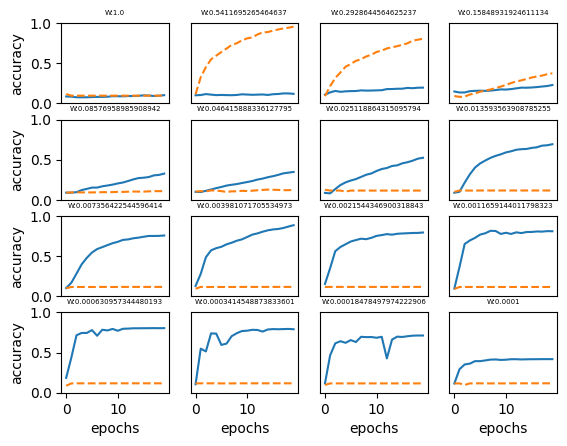

In [ ]:
(x_train,t_train),(x_test,t_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.reshape(60000,-1) #flatten (60000,28,28) - > (60000,784)
x_train = x_train.astype('float32') / 255. #normalize 데이터를 0과 1사이로

x_test = x_test.reshape(10000,-1)
x_test = x_test.astype('float32') / 255. #normalize 데이터를 0과 1사이로

# 학습 데이터를 줄임
x_train = x_train[:1000]
t_train = t_train[:1000]

max_epochs = 20
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.001


def __train(weight_init_std):
    bn_network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10,
                                    weight_init_std=weight_init_std, use_batchnorm=True)
    network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10,
                                weight_init_std=weight_init_std)
    optimizer = SGD(lr=learning_rate)

    train_acc_list = []
    bn_train_acc_list = []

    iter_per_epoch = max(train_size / batch_size, 1)
    epoch_cnt = 0

    for i in range(1000000000):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]

        for _network in (bn_network, network):
            grads = _network.gradient(x_batch, t_batch)
            optimizer.update(_network.params, grads)

        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)
            bn_train_acc = bn_network.accuracy(x_train, t_train)
            train_acc_list.append(train_acc)
            bn_train_acc_list.append(bn_train_acc)

            print("epoch:" + str(epoch_cnt) + " | " + str(train_acc) + " - " + str(bn_train_acc))

            epoch_cnt += 1
            if epoch_cnt >= max_epochs:
                break

    return train_acc_list, bn_train_acc_list


# 그래프 그리기==========
weight_scale_list = np.logspace(0, -4, num=16)
x = np.arange(max_epochs)

for i, w in enumerate(weight_scale_list):
    print( "============== " + str(i+1) + "/16" + " ==============")
    train_acc_list, bn_train_acc_list = __train(w)

    plt.subplot(4,4,i+1)
    plt.title("W:" + str(w), fontsize=5)
    if i == 15:
        #plt.plot(x, bn_train_acc_list, label='Batch Normalization', markevery=2)
        #plt.plot(x, train_acc_list, linestyle = "--", label='Normal(without BatchNorm)', markevery=2)
        plt.plot(x, bn_train_acc_list, markevery=2)
        plt.plot(x, train_acc_list, linestyle="--", markevery=2)
    else:
        plt.plot(x, bn_train_acc_list, markevery=2)
        plt.plot(x, train_acc_list, linestyle="--", markevery=2)

    plt.ylim(0, 1.0)
    if i % 4:
        plt.yticks([])
    else:
        plt.ylabel("accuracy")
    if i < 12:
        plt.xticks([])
    else:
        plt.xlabel("epochs")
    #plt.legend(loc='upper right')

plt.show()

 - 파란 실선 : 배치정규화 사용
 - 주황 점선 : 배치정규화 사용하지 않음

### 6.4 바른 학습을 위해

#### 6.4.1 오버피팅 억제
: train 데이터에만 fitiing 되어 새로운 test데이터가 들어왔을 때 제대로 판단하지 못함

- 매개변수가 많고 표현력이 높은 모델
- 훈련 데이터가 적음
- 가중치 매개변수 값이 큼


#### 6.4.2 가중치 감소

: 학습과정에서 큰 가중치에 대해서는 그에 상응하는 큰 패널티를 부과하여 오버피팅 억제

- 모든 가중치 각각의 손실함수에 1/2 λ (W\*\*2)
를 더함

- 람다 : 정규화 세기 조정
- 1/2 : 미분결과 조정 상수

### overfit weight decay MNIST TEST

epoch:0, train acc:0.10666666666666667, test acc:0.0988
epoch:1, train acc:0.12333333333333334, test acc:0.1052
epoch:2, train acc:0.14, test acc:0.1135
epoch:3, train acc:0.15666666666666668, test acc:0.1208
epoch:4, train acc:0.16666666666666666, test acc:0.1285
epoch:5, train acc:0.18666666666666668, test acc:0.1389
epoch:6, train acc:0.21333333333333335, test acc:0.1504
epoch:7, train acc:0.23, test acc:0.1585
epoch:8, train acc:0.24333333333333335, test acc:0.1658
epoch:9, train acc:0.25333333333333335, test acc:0.1712
epoch:10, train acc:0.26, test acc:0.1791
epoch:11, train acc:0.2833333333333333, test acc:0.1863
epoch:12, train acc:0.3, test acc:0.1943
epoch:13, train acc:0.32666666666666666, test acc:0.2028
epoch:14, train acc:0.3333333333333333, test acc:0.2123
epoch:15, train acc:0.3433333333333333, test acc:0.224
epoch:16, train acc:0.35, test acc:0.2326
epoch:17, train acc:0.36666666666666664, test acc:0.2426
epoch:18, train acc:0.36333333333333334, test acc:0.2495
epoch:1

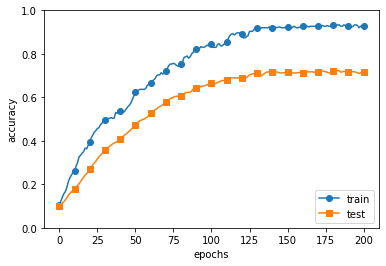

In [ ]:
(x_train,t_train),(x_test,t_test) = tf.keras.datasets.mnist.load_data()

#x_train = x_train.reshape(60000,-1) #flatten (60000,28,28) - > (60000,784)
#x_test = x_test.reshape(10000,-1)

x_train = x_train.reshape(60000,-1)
x_train = x_train.astype('float32') / 255. #normalize 데이터를 0과 1사이로

x_test = x_test.reshape(10000,-1)
x_test = x_test.astype('float32') / 255. #normalize 데이터를 0과 1사이로



# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

# weight decay（가중치 감쇠） 설정 =======================
#weight_decay_lambda = 0 # weight decay를 사용하지 않을 경우
weight_decay_lambda = 0.2
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambda)
optimizer = Adam(lr=0.0001) # 학습률이 0.0001인 SGD로 매개변수 갱신

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break


# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

#### 6.4.3 드롭아웃
: 복잡한 신경망 모델에서 은닉층의 뉴런을 무작위로 골라 삭제함
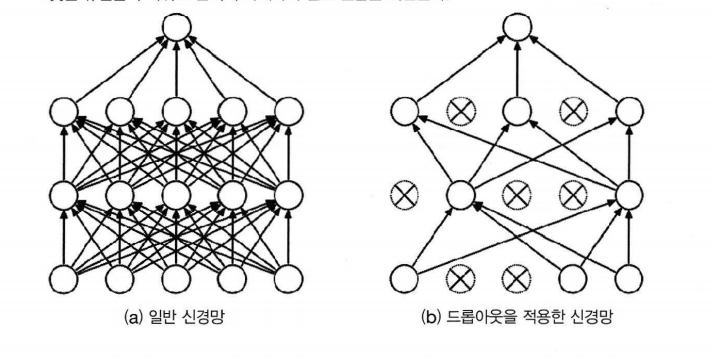

### dropout MNIST TEST

In [ ]:
(x_train,t_train),(x_test,t_test) = tf.keras.datasets.mnist.load_data()

#x_train = x_train.reshape(60000,-1) #flatten (60000,28,28) - > (60000,784)
#x_test = x_test.reshape(10000,-1)

x_train = x_train.reshape(60000,-1)
x_train = x_train.astype('float32') / 255. #normalize 데이터를 0과 1사이로
x_test = x_test.reshape(10000,-1)
x_test = x_test.astype('float32') / 255. #normalize 데이터를 0과 1사이로

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

# 드롭아웃 사용 유무와 비울 설정 ========================
use_dropout = True  # 드롭아웃을 쓰지 않을 때는 False
dropout_ratio = 0.2
# ====================================================

network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                              output_size=10, use_dropout=use_dropout, dropout_ration=dropout_ratio)
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=301, mini_batch_size=100,
                  optimizer = 'sgd', optimizer_param={'lr': 0.01}, verbose=True)
trainer.train()

train_acc_list, test_acc_list = trainer.train_acc_list, trainer.test_acc_list

# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

### 6.5 적절한 하이퍼 파라미터 값 찾기

#### 6.5.1 검증데이터
 : 하이퍼파라미터의 성능 평가용 / 훈련 데이터의 20%정도를 검증데이터로 먼저 분리함

In [ ]:
def shuffle_dataset(x, t):
    """데이터셋을 뒤섞는다.
    Parameters
    ----------
    x : 훈련 데이터
    t : 정답 레이블

    Returns
    -------
    x, t : 뒤섞은 훈련 데이터와 정답 레이블
    """
    permutation = np.random.permutation(x.shape[0])
    x = x[permutation,:] if x.ndim == 2 else x[permutation,:,:,:]
    t = t[permutation]

    return x, t

In [ ]:
'''실행 하지 말것 x'''
'''실행 하지 말것 x'''
'''실행 하지 말것 x'''
'''실행 하지 말것 x'''
'''실행 하지 말것 x'''

#(x_train, t_train), (x_test, t_test) = load _mnist()
(x_train,t_train),(x_test,t_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.reshape(10000,-1)
x_train = x_train.astype('float32') / 255. #normalize 데이터를 0과 1사이로

# 훈련 데이터를 뒤섞는다.
x_train, t_train = shuffle_dataset(x_train, t_train)

# 20%를 검증 데이터로 분할
validation_rate = 0.20
validation_num = int( x_train.shape[0] * validation_rate)

x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]

#### 6.5.2 하이퍼 파라미터 최적화
 : 대략적인 범위를 설정하고 그 범위에서 무작위로 하이퍼파라미터 값을 골라낸 후 그 값으로 정확도를 평가

- 0단계 : 하이퍼파라미터 값의 범위를 설정한다.
- 1단계 : 설정된 범위에서 하이퍼파라미터의 값을 무작위로 추출한다.
- 2단계 : 1단계에서 샘플링한 하이퍼파라미터 값을 사용하여 학습하고, 검증 데이터로 정확도를 평가한다.(단, 에폭은 작게 설정한다.)
- 3단계 : 1단계와 2단계를 특정 횟수(100회 등) 반복하며, 그 정확도의 결과를 보고 하이퍼파라미터의 범위를 좁힌다.

: 위 방법은 실용적인 방법(수행자의 직관과 지혜에 의존)

: 세련된 방법은 베이즈 최적화(Bayesian optimization)
  - "practical bayesian optimization of machine learning algorithms" 논문 참고

#### 6.5.3 하이퍼 파라미터 최적화 구현하기

(500, 28, 28) (500,)
val acc:0.33 | lr:3.810709290569502e-05, weight decay:4.614404379047091e-06
val acc:0.15 | lr:2.160832933539896e-06, weight decay:1.264172842532255e-05
val acc:0.17 | lr:2.176256169023555e-06, weight decay:1.0730198861943462e-07
val acc:0.38 | lr:0.00016930445769860935, weight decay:1.4094504330903511e-08
val acc:0.35 | lr:2.4593878385127705e-05, weight decay:4.533882462216341e-07
val acc:0.19 | lr:3.379890817000958e-06, weight decay:3.375007128895183e-08
val acc:0.22 | lr:1.6508431777498255e-05, weight decay:3.189732412008876e-08
val acc:0.25 | lr:5.0106473115735e-06, weight decay:2.0104907647201135e-05
val acc:0.1 | lr:0.005235604114330209, weight decay:9.751500408950149e-07
val acc:0.39 | lr:4.903335077618886e-05, weight decay:1.5452181672400066e-06
val acc:0.48 | lr:0.0002610583519091252, weight decay:3.41273931130668e-05
val acc:0.28 | lr:0.0001168656184230502, weight decay:2.3822321383031432e-07
val acc:0.53 | lr:0.0001926626681974857, weight decay:9.91830458

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: overflow encountered in square


val acc:0.1 | lr:0.0048726663614408194, weight decay:2.140701405013726e-08
val acc:0.19 | lr:1.376498504561851e-06, weight decay:7.123678794967844e-06
val acc:0.1 | lr:0.005473952841697715, weight decay:1.1613293551591057e-05
val acc:0.45 | lr:4.114010978380625e-05, weight decay:5.082979632662121e-05
val acc:0.18 | lr:1.2409619969488246e-06, weight decay:6.811484545728892e-06
val acc:0.26 | lr:5.353751433526613e-06, weight decay:7.537802449520585e-05
val acc:0.42 | lr:1.0452929022241849e-05, weight decay:1.925380542959468e-08
val acc:0.11 | lr:1.3150710156264907e-06, weight decay:5.443077337775641e-07
val acc:0.34 | lr:0.00022488774865151549, weight decay:5.096714774594977e-05
val acc:0.17 | lr:4.23653155430537e-06, weight decay:4.185367152976964e-05
val acc:0.34 | lr:1.4479186459517136e-05, weight decay:1.0094863278102863e-07
val acc:0.44 | lr:0.0012968556167698626, weight decay:4.0551065466052595e-07
val acc:0.2 | lr:1.4940772668515416e-06, weight decay:3.9373739943446683e-07
val acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in subtract
  after removing the cwd from sys.path.


val acc:0.1 | lr:0.002916027013631132, weight decay:1.6149005414267408e-07
val acc:0.11 | lr:2.8157752457353314e-06, weight decay:5.690306998617753e-07
val acc:0.18 | lr:0.0019600945158207202, weight decay:7.651821768968135e-05
val acc:0.46 | lr:0.0003932887890734965, weight decay:2.2852633000699777e-05
val acc:0.18 | lr:1.657860283970187e-06, weight decay:4.9460457909807404e-08
val acc:0.16 | lr:1.0930265944387182e-06, weight decay:1.807588940876876e-07
val acc:0.34 | lr:1.1211228914317323e-05, weight decay:1.7392377723273617e-05
val acc:0.11 | lr:1.8379347791009677e-06, weight decay:2.915340044832464e-06
val acc:0.38 | lr:0.00013956177974626437, weight decay:1.5530240436592692e-05
val acc:0.38 | lr:1.3632460150608271e-05, weight decay:8.571765458313812e-07
val acc:0.13 | lr:2.99941186921572e-06, weight decay:1.6488396412100886e-07


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in subtract
  after removing the cwd from sys.path.


val acc:0.1 | lr:0.0036722313762660727, weight decay:4.564280163761984e-06
val acc:0.5 | lr:0.0012273061405345248, weight decay:3.491458844714482e-05
val acc:0.54 | lr:0.00012473109791017633, weight decay:2.322297057116454e-06
val acc:0.42 | lr:0.0024660655154518855, weight decay:1.4352475198611347e-05
val acc:0.47 | lr:0.00019392673859805243, weight decay:9.980073175319873e-06
val acc:0.19 | lr:3.87181092058778e-06, weight decay:1.0034840869870734e-07
val acc:0.1 | lr:0.003784408524290895, weight decay:4.349290897602506e-06
val acc:0.27 | lr:7.937087018083735e-06, weight decay:2.6711814773048535e-08
val acc:0.42 | lr:0.00030540499280555343, weight decay:8.656141403370484e-05
val acc:0.41 | lr:6.759426671350818e-05, weight decay:3.806154814495859e-05
val acc:0.21 | lr:7.807046320154843e-06, weight decay:1.4130911116187629e-05
val acc:0.49 | lr:0.0002503513962682665, weight decay:2.590481328038161e-08
val acc:0.33 | lr:3.9126797060201794e-05, weight decay:5.657700068205994e-07
val acc:0

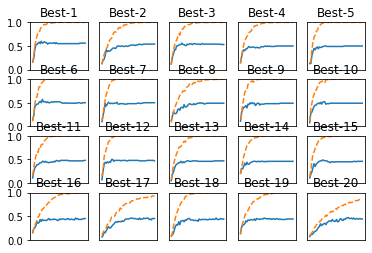

In [ ]:
(x_train,t_train),(x_test,t_test) = tf.keras.datasets.mnist.load_data()

#x_train = x_train.reshape(60000,-1) #flatten (60000,28,28) - > (60000,784)
#x_test = x_test.reshape(10000,-1)

x_test = x_test.reshape(10000,-1)
x_test = x_test.astype('float32') / 255. #normalize 데이터를 0과 1사이로
x_test = x_test.reshape(10000, 28, 28)

# 결과를 빠르게 얻기 위해 훈련 데이터를 줄임
x_train = x_train[:500]
t_train = t_train[:500]

print(x_train.shape, t_train.shape)
x_train = x_train.reshape(500, -1)

# 20%를 검증 데이터로 분할
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)
x_train, t_train = shuffle_dataset(x_train, t_train)
x_train = x_train.reshape(500, 28, 28)
x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]


def __train(lr, weight_decay, epocs=50):
    network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                            output_size=10, weight_decay_lambda=weight_decay)
    trainer = Trainer(network, x_train, t_train, x_val, t_val,
                      epochs=epocs, mini_batch_size=100,
                      optimizer='sgd', optimizer_param={'lr': lr}, verbose=False)
    trainer.train()

    return trainer.test_acc_list, trainer.train_acc_list


# 하이퍼파라미터 무작위 탐색======================================
optimization_trial = 100
results_val = {}
results_train = {}
for _ in range(optimization_trial):
    # 탐색한 하이퍼파라미터의 범위 지정===============
    weight_decay = 10 ** np.random.uniform(-8, -4)
    lr = 10 ** np.random.uniform(-6, -2)
    # ================================================

    val_acc_list, train_acc_list = __train(lr, weight_decay)
    print("val acc:" + str(val_acc_list[-1]) + " | lr:" + str(lr) + ", weight decay:" + str(weight_decay))
    key = "lr:" + str(lr) + ", weight decay:" + str(weight_decay)
    results_val[key] = val_acc_list
    results_train[key] = train_acc_list

# 그래프 그리기========================================================
print("=========== Hyper-Parameter Optimization Result ===========")
graph_draw_num = 20
col_num = 5
row_num = int(np.ceil(graph_draw_num / col_num))
i = 0

for key, val_acc_list in sorted(results_val.items(), key=lambda x:x[1][-1], reverse=True):
    print("Best-" + str(i+1) + "(val acc:" + str(val_acc_list[-1]) + ") | " + key)

    plt.subplot(row_num, col_num, i+1)
    plt.title("Best-" + str(i+1))
    plt.ylim(0.0, 1.0)
    if i % 5: plt.yticks([])
    plt.xticks([])
    x = np.arange(len(val_acc_list))
    plt.plot(x, val_acc_list)
    plt.plot(x, results_train[key], "--")
    i += 1

    if i >= graph_draw_num:
        break

plt.show()

$$ y = wx+b $$
<br>
#$$ y = wx+b $$



collections 모듈 - OrderedDict

https://www.daleseo.com/python-collections-ordered-dict/

https://excelsior-cjh.tistory.com/98